# Text Classification  -  Sentiment Analysis - TfidfVectorizer

- Apply Text Vectorization TfIdfVectorization
- Apply Classification models to text vector to predict whether the rating is positive or negative
- Select the best performing models 

##  Required packages

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

from time import time
from sklearn import metrics

from sklearn import svm
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from IPython.core.display import display, HTML

# import customised plotting functions from plot_mtrics.py script
from plot_metrics import plot_metrics_and_time, plot_radar_metrics, plot_radar_mult
from plot_metrics import plot_radar_some, barplot_metric_mult, stack_barplot
from plot_metrics import stack_mult_barplots, lineplot_models_vs_metrics

## Load data & Split into training and test data

In [3]:
# load the data
df = pd.read_csv("data_to_vect.csv" , index_col=0)

# display first lines of the data
display(df.head())

# check nan values
print(df.isna().sum())

print(df.info())

# the target variable is 0 if rating <= 3 and 1 if rating >= 4
y = (df["rating"]>3)*1  

# explanatory variable : the stemmed comment
X = df["comment_stem"]

# Set the test size at 25% of the overall sample.
# Set stratify = y to preserve labels repartition on training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.25, 
                                                    stratify=y,
                                                    random_state=23)

,comment,rating,comment_cleaned,comment_lemmatized,comment_stem,stem_len
0,"Facilte, sollicitations dosées...qualité..on p...",4,facilte sollicitations dosées qualité pourrait...,facilte sollicitation doser qualité pouvoir ce...,facilt sollicit dos qualit pouvoir cepend amél...,558
1,Livraison impeccable avec possibilité de prend...,4,livraison impeccable possibilité prendre samed...,livraison impeccable possibilité prendre samed...,livraison impecc possibil prendr samed matin b...,461
2,Achat d'un canapé La Redoute intérieurs le 6/9...,4,achat canapé redoute intérieurs site redoute a...,achat canapé redoute intérieur site redoute ab...,achat canap redout intérieur sit redout abord ...,426
3,je commande depuis longtemps chez la redoute; ...,4,commande depuis longtemps redoute appréciais c...,commande depuis longtemps redoute appréciai ch...,command depuis longtemp redout appréci choix r...,370
4,"Comme d'habitude, aucun souci et rapidité d'ex...",5,habitude aucun souci rapidité expédition colis...,habitude aucun souci rapidité expédition colis...,habitud aucun souc rapid expédit colis bravo d...,366


comment               0
rating                0
comment_cleaned       0
comment_lemmatized    0
comment_stem          0
stem_len              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 22683 entries, 0 to 23466
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comment             22683 non-null  object
 1   rating              22683 non-null  int64 
 2   comment_cleaned     22683 non-null  object
 3   comment_lemmatized  22683 non-null  object
 4   comment_stem        22683 non-null  object
 5   stem_len            22683 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.2+ MB
None


## Preprocessing with TF-IDF
- TF-IDF
- RandomUnderSampling

In [4]:
#vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, sublinear_tf=True, use_idf=True)
tfvectorizer = TfidfVectorizer()

V_train = tfvectorizer.fit_transform(X_train).toarray()
V_test = tfvectorizer.transform(X_test).toarray()

# Undersampling to tackle classes imbalance
ru = RandomUnderSampler()
V_ru, y_ru = ru.fit_resample(V_train, y_train)

print("Shape of random undersampled train features:", V_ru.shape)
print("Shape of random undersampled train labels:", y_ru.shape)


Shape of random undersampled train features: (4034, 5118)
Shape of random undersampled train labels: (4034,)


##  Models training and Evaluation

### Function to fit and evaluate a model

In [5]:
# function to fit a model and calculate its metrics, time performance, classification report and confusion matrix

def fit_and_evaluate(model_name, model, encoder=0):
    """ function to fit a model and calculate its metrics and time performance
        return a dataFrame of metrics and time performance
        encoder = 0  => fit on X_train, y_train without undersampling 
        encoder = 1 => fit on random undersampled TfIdfVectorize train data
    """
    # Fit the model to the training data
    t0 = time()
    if encoder == 0:
        model.fit(X_train, y_train) # model fit directly on original X_train, y_train. To be used with pipeline
    elif encoder == 1:
        model.fit(V_ru, y_ru)  # model fit on the random under-sampled tf-idf vectorized train data
    t1 = time()
    
    # Prediction on the tf-idf vectorized test data
    if encoder == 0: 
        prediction = model.predict(X_test) 
    else:
        prediction = model.predict(V_test) 
   
    t2 = time()
    time_train = t1-t0
    time_predict = t2-t1

    # Evaluate model performance
    if encoder == 0: 
        accuracy = model.score(X_test, y_test)
    else:
        accuracy = model.score(V_test, y_test)
    
    # The balanced accuracy in binary and multiclass classification problems 
    # to deal with imbalanced datasets.
    # It is defined as the average of recall obtained on each class.
    # The best value is 1 and the worst value is 0 when adjusted=False.
    balanced_accuracy = metrics.balanced_accuracy_score(y_test, prediction)   
    
    f1_score = metrics.f1_score(y_test, prediction)
    f1_score_macro = metrics.f1_score(y_test, prediction, average="macro")
    f1_score_weighted = metrics.f1_score(y_test, prediction, average="weighted")
    
    recall = metrics.recall_score(y_test, prediction, pos_label=0)
    recall_macro = metrics.recall_score(y_test, prediction, average="macro")
    recall_weighted = metrics.recall_score(y_test, prediction, average="weighted")
    
    # precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
    # we set pos_label=0 : that is negative rating (rating <=3)
    precision = metrics.precision_score(y_test, prediction, pos_label=0)
    precision_macro = metrics.precision_score(y_test, prediction, average="macro" )
    precision_weighted = metrics.precision_score(y_test, prediction, average="weighted")

    cl_report = metrics.classification_report(y_test, prediction)
    cf_matrix = pd.crosstab(y_test, prediction, rownames = ["Real"], colnames=["Prediction"])

    # put metrics  into a dictionnary and into a DataFrame
    res = {"model": model_name, 
           "accuracy": accuracy, "balanced_accuracy": balanced_accuracy, 
           "f1": f1_score, "f1_macro": f1_score_macro, "f1_weighted": f1_score_weighted,
           "recall_0": recall, "recall_macro": recall_macro, "recall_weighted": recall_weighted,
           "precision_0" : precision, "precision_macro" : precision_macro, "precision_weighted" : precision_weighted,
            "time_train":time_train, "time_predict": time_predict}

    #DataFrame of model's performance
    df_p = pd.DataFrame(res, index=[0])

    #output model performance, classification report and confusion matrix
    return (df_p, cl_report, cf_matrix)
    

### Function to visualize models performance

###  Models to train and evaluate
- Logistitics Regression
- Decision Trees
- Random Forest

- LinearSVC
- SVC
- MultinomialNB
- ComplementNB
- GaussianNB
  
- KNN
- Gradient Boost models

### Classification of text vectorize with TF-IDF

#### fit models and evaluate

In [6]:
# list of models (model name an model instance) to train and evaluate
models_list = [("Logistic_reg", LogisticRegression()),
               ("Decision_tree", DecisionTreeClassifier()),
               ("Random_forest", RandomForestClassifier()),
               ("LinearSVC", svm.LinearSVC()),
               ("SVC(kernel=rbf)", svm.SVC()),
               ("MultinomialNB", MultinomialNB()),
               ("GaussianNB", GaussianNB()),
               ("ComplementNB", ComplementNB()),
               ("KNN", KNeighborsClassifier()),
               ("Gradient Boosting Classifier", GradientBoostingClassifier())]


In [7]:
# Train and evaluate the models after tf-idf transformed data

list_of_models = []
cf_matrix = []
cl_report = []
df_perf = pd.DataFrame([])

for (model_name, model) in models_list:    
    (df0, clrep, cfmx)  = fit_and_evaluate(model_name, model, encoder=1)
    print("time ",time(),": "+model_name + " fitted and evaluated.")
    list_of_models.append(model_name)
    df_perf = pd.concat([df_perf, df0])
    cl_report.append(clrep)
    cf_matrix.append(cfmx)

df_perf = df_perf.reset_index().drop("index", axis = 1)   


time  1701599554.808927 : Logistic_reg fitted and evaluated.
time  1701599559.500515 : Decision_tree fitted and evaluated.
time  1701599569.943208 : Random_forest fitted and evaluated.
time  1701599570.231433 : LinearSVC fitted and evaluated.
time  1701600888.94658 : SVC(kernel=rbf) fitted and evaluated.
time  1701600889.138172 : MultinomialNB fitted and evaluated.
time  1701600891.67626 : GaussianNB fitted and evaluated.
time  1701600891.933692 : ComplementNB fitted and evaluated.
time  1701600900.0876071 : KNN fitted and evaluated.
time  1701600972.646904 : Gradient Boosting Classifier fitted and evaluated.


In [8]:
# Save metrics into a csv_file
df_temp=df_perf.copy()
df_temp["model"] = df_temp["model"]+"_tfidf"
df_temp.to_csv("perf_tfidf.csv")
del df_temp

#### Visualize and compare models performance

In [9]:
# Comparison of metrics scores
data = df_perf.iloc[:,:-2]  # to skip time_train and time_predict
plot_radar_mult(data)



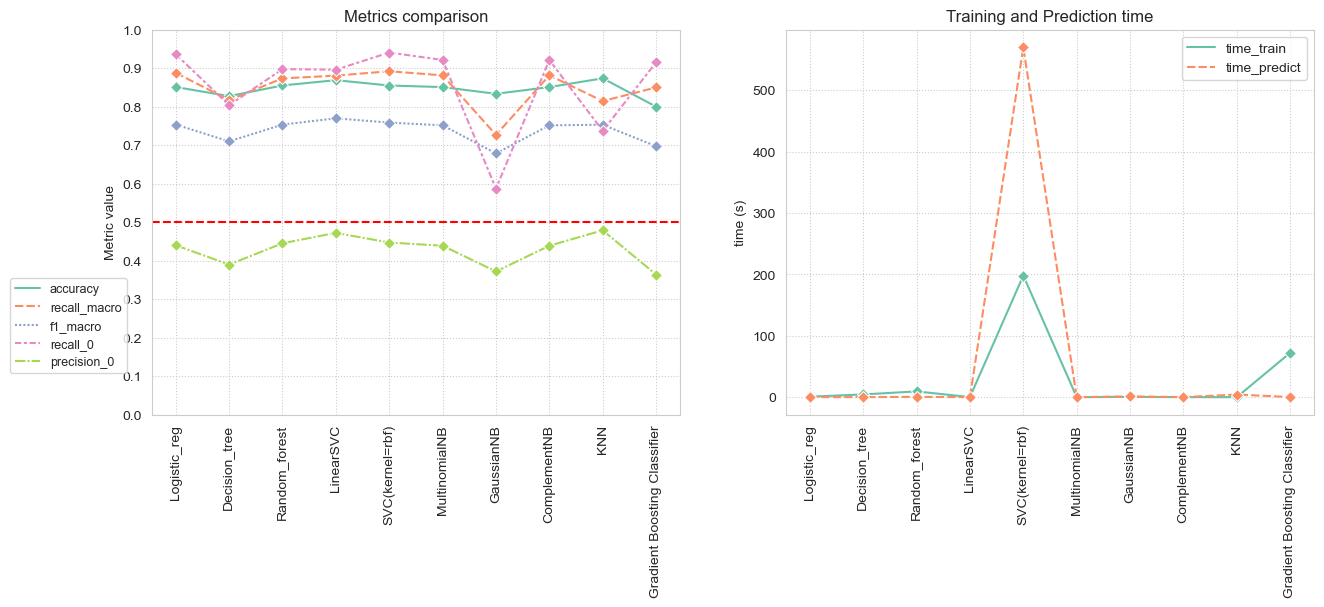

In [10]:
# Compare metrics and time to train and time to predict
plot_metrics_and_time(df_perf)

In [11]:
# Top 4 best models and Top1 model

top4 = ["Logistic_reg", "LinearSVC", "MultinomialNB", "ComplementNB"]
top1 = ["LinearSVC"]
top4_data = data[data["model"].isin(top4)]
top1_data = data[data["model"].isin(top1)]
plot_radar_mult(top4_data)


In [12]:
# Line plot to compare of five selected metrics
lineplot_models_vs_metrics(data[["model", "accuracy", "recall_0", "recall_macro", "precision_0", "precision_macro" ]])

In [13]:
# Group bar plot on 5 selected metrics
stack_mult_barplots(data, "accuracy", "recall_0", "recall_macro", "precision_0", "precision_macro" )

In [14]:
# Group bar plot on 5 selected metrics for top4 models
stack_mult_barplots(top4_data, "accuracy", "recall_0", "recall_macro", "precision_0", "precision_macro" )

In [15]:
# Top1 best model 
# Group bar plot on 5 selected metrics for top4 models
stack_mult_barplots(top1_data, "accuracy", "recall_0", "recall_macro", "precision_0", "precision_macro" )

In [16]:
# Comparaison of Accuracy, recall_macro, precision_macro, recall_0, precision_0
for metric in ["accuracy", "recall_macro", "precision_macro", "recall_0", "precision_0"]:
    barplot_metric_mult(data, metric)

In [17]:
# Compare time_train and time_predict 
stack_barplot(df_perf, "time_train", "time_predict")

# Compare recall_macro and precision_macro
stack_barplot(df_perf, "recall_macro", "precision_macro")

In [18]:
#function to visualize confusion matrix side by side

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))



In [19]:
# confusion matrix
#Display(confusion matrix)
display_side_by_side(cf_matrix, list_of_models)


Prediction,0,1
Real,,
0,630,43
1,802,4196
Prediction,0,1
Real,,
0,541,132
1,847,4151
Prediction,0,1
Real,,
0,604,69
